### Анализ полученных данных

In [100]:
import pandas as pd
import numpy as np

# импорт функций
from func_replace_letter import replace_letter as rep_let

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [101]:
data = pd.read_csv('data.csv', sep=';')

In [102]:
data['dateTime'] = pd.to_datetime(data.dateTime, format='%Y-%m-%d %H:%M:%S')
# переводим столбец в формат даты и времени

Далее не много посмотрим на данные. В результате предварительного анализа, можем обнаружить, что наши данные имеют не корректное представление. Некоторые схожие с русскими буквами представлены на английском языке. Для того, чтобы это обнаружить, воспользуемся функцией `lower()`, которая переводит все символы в нижний регистр.

In [103]:
data.productName.str.lower()

0           cалаt "oлиbьe" (сoбствeh =
1      шоkoлад (мон' дэлис руcь) "ми =
2      печеньe (тулa) maффин "ильинс =
3      cыpоk глазир. (б.ю.aлеkсahдpо =
4      бx: бymагa тyалетhая "mягkий  =
                    ...               
321         п/ф карбoнад cвиhoй (п/ф =
322         pыба koпч.(арт-pыба) 3уб =
323    cmetahа (toтьмa) "boлогoдская =
324    cmеtаhа (тотьma) "bолoгoдckaя =
325     твоpoг (тотьмa) oбeзжирehhый =
Name: productName, Length: 326, dtype: object

Чтобы устранить не корректный ввод данных, создадим функцию `replace_letter`, которая заменяет английские символы на русские `k -> к` и возвращает исправленное наименование товара в нижнем регистре.

Функция описана в файле `func_replace_letter.py`

In [106]:
data['productName'] = data.productName.apply(rep_let)

In [107]:
print('Всего кол-во позиций:', data.shape[0], sep='\t')
# обратим внимание, что мы имеем 326 уникальных позиций товара
print('Всего кол-во чеков:', data.dateTime.nunique(), sep='\t')
# а также данные содержат всего 84 чека в промежутке с 1 апр.2022 по 8 нояб.2022

Всего кол-во позиций:	326
Всего кол-во чеков:	84


Данные загружены и отредактированы. С 1 апреля по 8 ноября имеется всего 84 чека, что является незначительным для такого промежутка времени. Сгруппируем данные по дате и визуализируем общую сумму покупок в каждом месяце.

In [110]:
data_group_date = data \
    .groupby('dateTime', as_index=False) \
    .agg({'purchaseAmount': 'sum'})

In [111]:
data_group_month = data.set_index(data.dateTime).purchaseAmount.resample('M').sum().to_frame().reset_index()

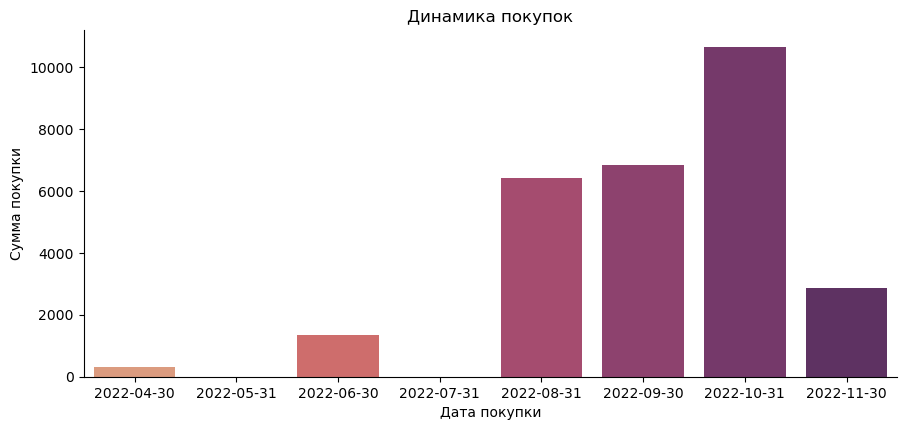

In [112]:
plt.figure(figsize=(10.5, 4.5))
ax = sns.barplot(data=data_group_month, x='dateTime', y='purchaseAmount',
                 palette="flare") # строим график
ax.set(xlabel='Дата покупки', ylabel='Сумма покупки', title='Динамика покупок') # именуем оси, наименовние графика
ax.set_xticklabels(data_group_month.dateTime.dt.date)
sns.despine() # убираем часть рамки
plt.show() # печатаем график

По данному графику можно сделать вывод, что с `апреля` по `июль` кол-во покупок незначительно, поэтому для дальнейшего анализа оставим в выборке значения с `августа 2022` года.